In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import i0
from scipy.special import i1
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
from cmath import rect
from scipy.signal import savgol_filter
import seaborn as sns
from scipy.ndimage import convolve1d
from matplotlib import animation
from matplotlib import rc as matrc
from matplotlib import rcParams
from IPython.display import HTML
from scipy.optimize import curve_fit
import custom_plot as cplt

matrc('animation', html='jshtml', embed_limit=20971520*2)

In [2]:
def set_style(tex=False, box=False, ymargin=0.0, xmargin=0.0):
    nice_fonts = {
            # Use LaTeX to write all text
            "text.usetex": tex,
            "font.family": "serif",
            "axes.labelsize": 11,
            "font.size": 9,
            "legend.fontsize": 8,
            "xtick.labelsize": 9,
            "ytick.labelsize": 9,
    }
    rcParams.update(nice_fonts)
    rcParams['axes.xmargin'] = xmargin
    rcParams['axes.ymargin'] = ymargin
    rcParams["axes.spines.right"] = box
    rcParams["axes.spines.top"] = box

def M(mu, kappa):
    return lambda x: np.exp(kappa*np.cos(x-mu))/(2*np.pi*i0(kappa))

def Gaussian(mu, sigma, A=None):
    if A is None:
        return lambda x: 1 / np.sqrt(2*np.pi*sigma**2) * np.exp(-(x-mu)**2/(2*sigma**2))
    else:
        return lambda x: A * np.exp(-(x-mu)**2/(2*sigma**2))

def norm(f, kappa, beta):
    """
    Firing rate (normalization) in the continuous theta case and 
    where u(theta) follows von Mises distribution
    """
    c = 1 + beta/(2*np.pi) * i0(2*kappa)/i0(kappa)**2
    return lambda x: f(x)**2 / c

def mean(data, axis=0, weights=None):
    """
    Mean of data. Can calculate weighted mean, where each datum is weighted
    by its corresponding entry in WEIGHTS.
    """
    data = np.array(data)
    return np.average(data, axis=axis, weights=weights)

def stddev(data, axis=0, ddof=1, weights=None, delta=None):
    """
    Calculates standard deviation of data. ddof is the degrees of freedom, and
    is usually 1.
    """
    data = np.array(data)
    if weights is not None:
        V = sum(weights)
        avg = mean(data, axis=axis, weights=weights)
        variance = mean((data-avg)**2, axis=axis, weights=weights) * V / (V - ddof)
        dev = np.sqrt(variance)
    else:
        dev = np.std(data, axis=axis, ddof=ddof)
    if delta is None:
        return dev
    delta = np.array(delta)
    return np.sqrt(dev**2 + delta**2)

def stderr(data, axis=0, ddof=1, weights=None, delta=None):
    """
    Calculates standard error of data.
    """
    data = np.array(data)
    if delta is None:
        return stddev(data, axis=axis, ddof=ddof, weights=weights)/np.sqrt(len(data))
    delta = np.array(delta)
    return np.sqrt(sum(stddev(data, axis=axis, ddof=ddof, weights=weights, delta=delta)**2))/len(data)

def perm_mat(size, k):
    """
    Returns a permutation matrix that shifts element
    to the right by k along the first axis
    """
    a = np.zeros(size)
    for i, row in enumerate(a):
        index = (i+k) % len(a)
        row[index] = 1
    return a

def my_reset(*varnames):
    """
    Free up all variables except varnames, which are what you want to keep.
    Used when memory is low or something. Example use:
    my_reset('wc10', 'wc20')
    which will free up all variables but wc10 and wc20.
    """
    globals_ = globals()
    to_save = {v: globals_[v] for v in varnames}
    to_save['my_reset'] = my_reset
    del globals_
    get_ipython().magic("reset")
    globals().update(to_save)
    
def calc_corr(a, b):
    """
    Calculates correlation between two vectors. Can call np.corrcoef(a, b)[:N,N:] 
    as well, where N = len(a) = len(b)
    """
    a_bar = mean(a)
    b_bar = mean(b)
    return np.dot(a-a_bar, b-b_bar)/(np.linalg.norm(a-a_bar)*np.linalg.norm(b-b_bar))

In [3]:
def r(ui, u, omega):
    """
    Firing rate (normalization) of ui in the discrete theta case,
    as a function of all neurons' u, and parameter omega.
    """
    zeros = np.zeros(len(u))
    return np.maximum(ui, 0)**2.0 / (1 + omega * np.sum(np.maximum(u, zeros)**2.0))

def init_weights(N, mu, sigma, thetas):
    """
    Initialize N*N feedforward weights somewhat randomly. For each neuron, assign
    a random strength parameter distributed as a log-normal distribution
    with mean MU and standard deviation SIGMA. Each neuron's feedforward connection
    is a von Mises distribution with concentration 2, scaled by its strength, and with
    a Gaussian white noise with variance = 0.5 * mean. The center of the feedforward 
    projection is random.
    """
    strengths = np.random.lognormal(mean=mu, sigma=sigma, size=N) # neuron strengths
    w = np.zeros((N,N)) # feedforward weights. row is input neuron.
    for i, theta in enumerate(thetas):
        distrb = lambda thetas: strengths[i] * M(theta, 2)(thetas) # von Mises feedforward weights scaled by strength
        # add Gaussian noise and force weights to be non-negative
        w[i] = np.maximum(distrb(thetas) + np.random.normal(size=N, scale=np.sqrt(0.5*distrb(thetas))), np.zeros(N))
    np.random.shuffle(w) # shuffle by row (input neurons), so connectivitiy is random.
    return w.T.flatten() # transpose weight matrix and flatten it

def Newton(f, y0, ts, save_ts, progress=True):
    """
    Simulate the differential equation dydt = f(y) with Newton's method.
    Initialize y = y0. ts is an array of the simulation timesteps, and
    save_ts is an array of the timesteps at which y should be copied
    to the output results ys. save_ts should be evenly spaced
    """
    ys = np.zeros((len(save_ts), len(y0)))
    r1_in_save = np.zeros((len(save_ts), N))
    r2_in_save = np.zeros((len(save_ts), N))
    y = y0
    dt = ts[1] - ts[0]
    k = -1
    # assume save_ts is evenly spaced, then skip is # of simulation timesteps skipped between copying y to the results
    skip = int(round(len(ts)/(len(save_ts)-1)))
    # save all rc and ro values
    all_rc = np.zeros((len(ts)+1,N))
    all_ro = np.zeros((len(ts)+1,N))
    for i, t in enumerate(ts):
        if progress is True:
            print("Iteration: ", i)
        if i % skip == 0:
            # copy simulation data to outputs
            k += 1
            ys[k] = y
            r1_in_save[k] = r1_in[i]
            r2_in_save[k] = r2_in[i]
        uc, uo = y[:N], y[N:2*N]
        all_rc[i], all_ro[i] = r(uc, uc, omega), r(uo, uo, omega)
        
        y = y + dt*f(t, y, i, all_rc)
        
        # Set excitatory synapses to non-negative, inhibitory to non-positive
        w, thc, tho = y[2*N:-2*N], y[-2*N:-N], y[-N:]
        assert len(w) == 4*N*N
        wpos, wneg = w[:3*N*N], w[3*N*N:]
        # both excitatory and inhibitory connections are rectified positively, as negative sign
        # is added to inhibitory input in the dynamical equations.
        wpos, wneg = np.maximum(wpos, np.zeros(3*N*N)), np.maximum(wneg, np.zeros(N*N))
        w = np.concatenate((wpos, wneg))
        y[2*N:-2*N] = w
        
    ys[-1] = y
    uc, uo = y[:N], y[N:2*N]
    all_rc[-1], all_ro[-1] = r(uc, uc, omega), r(uo, uo, omega)
    return (save_ts, ys, r1_in_save, r2_in_save, [all_rc, all_ro])

## Learning the feedforward weights

## Input

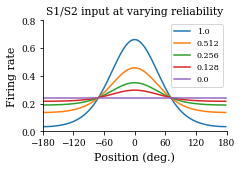

In [11]:
baseline = lambda R, a: 1.0*(1-R) * np.exp(-3.0)*i0(3.0)
lamb = lambda s, R, a: lambda theta_j: R*np.exp(-3.0)*i0(3.0)/i0(a)*np.exp(a*np.cos(s-theta_j)) + baseline(R,a) # von Mises distribution of mean firing rate
N = 180
thetas = np.linspace(-np.pi, np.pi, num=N, endpoint=False)

set_style()
reliability = [1.0, 0.512, 0.256, 0.128, 0.0]
r1_inss = [lamb(0.0, reliability[i], 1.5)(thetas) for i in range(len(reliability))]
plt.figure(figsize=cplt.set_size("nips", fraction=0.6))
for i in range(len(reliability)):
    plt.plot(np.rad2deg(thetas), r1_inss[i], label=str(reliability[i]))
plt.ylim(0, 0.8)
plt.xticks(np.arange(-180, 180.01, 60))
plt.title("S1/S2 input at varying reliability")
plt.xlabel("Position (deg.)")
plt.ylabel("Firing rate")
plt.legend()
# cplt.savefig("Manuscript/Figures/input_reliability.pdf")
plt.show()

## Initialization of weights

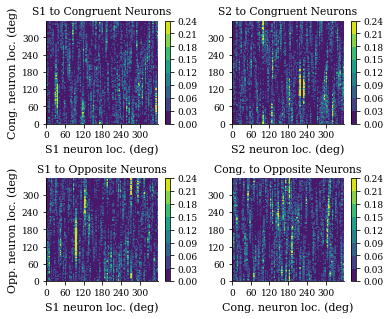

In [12]:
w0 = np.loadtxt("Initialization/initial_weights.csv")
l = N*N
wc10, wc20, wo10, wo20 = [np.reshape(w0[i*l:(i+1)*l], (N,N)) for i in range(4)]

levels = np.linspace(0.0, 0.24, num=9)
ticks = np.arange(0, 180, 30)
tick_labels = np.arange(0, 360, 60)
fig, axes = plt.subplots(2,2, figsize=cplt.set_size("nips", fraction=1.0, ratio=0.82))
c0 = axes[0][0].contourf(wc10, levels)
fig.colorbar(c0, ax=axes[0][0], ticks=levels)
axes[0][0].set_title("S1 to Congruent Neurons")
axes[0][0].set_ylabel("Cong. neuron loc. (deg)")
axes[0][0].set_xlabel("S1 neuron loc. (deg)")
c1 = axes[0][1].contourf(wc20, levels)
fig.colorbar(c1, ax=axes[0][1], ticks=levels)
axes[0][1].set_title("S2 to Congruent Neurons")
# axes[0][1].set_ylabel("Cong. neuron loc. (deg)")
axes[0][1].set_xlabel("S2 neuron loc. (deg)")
c2 = axes[1][0].contourf(wo10, levels)
fig.colorbar(c2, ax=axes[1][0], ticks=levels)
axes[1][0].set_title("S1 to Opposite Neurons")
axes[1][0].set_ylabel("Opp. neuron loc. (deg)")
axes[1][0].set_xlabel("S1 neuron loc. (deg)")
c3 = axes[1][1].contourf(wo20, levels)
fig.colorbar(c3, ax=axes[1][1], ticks=levels)
axes[1][1].set_title("Cong. to Opposite Neurons")
# axes[1][1].set_ylabel("Opp. neuron loc. (deg)")
axes[1][1].set_xlabel("Cong. neuron loc. (deg)")
for i in range(2):
    for j in range(2):
        axes[j][i].set_xticks(ticks)
        axes[j][i].set_xticklabels(tick_labels)
        axes[j][i].set_yticks(ticks)
        axes[j][i].set_yticklabels(tick_labels)
plt.tight_layout()
# plt.savefig("Manuscript/Figures/w0_matrix.png")
# cplt.savefig("Manuscript/Figures/w0_matrix.pdf")
plt.show()